# Netflix Content Strategy Analysis

Our **Goal** is to analyze Netflix's library to understand their content trends (e.g., "Is Netflix focusing more on TV Shows than Movies?") and find data quality issues.

Through this we will learn pandas and data analysis at a deeper level.



Before we analyze, we can first inspect the data to see what is broken

Below is a Toolkit for you 
| **Method**            | **Purpose**                                                         |
| --------------------- | ------------------------------------------------------------------- |
| `pd.read_csv()`       | Loads your data from a file into a DataFrame.                       |
| `.head(n)`            | Shows the first $n$ rows (default is 5).                            |
| `.info()`             | **The most important.** Shows data types and missing (null) counts. |
| `.describe()`         | Gives statistical summary (mean, min, max) for numbers.             |
| `.isnull().sum()`     | Counts exactly how many "holes" are in each column.                 |
| `.duplicated().sum()` | Tells you if you have any repeating rows.                           |



## Step 1 loading and inspection

In [1]:
import pandas as pd

df = pd.read_csv("netflix_titles.csv")

print("the first 5 rows:\n", df.head())

the first 5 rows:
   show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  Septemb

In [2]:
df.info() # check the health of the data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [3]:
# check for missing values
#print(df.isna()) # you got a boolean dataframe
print(df.isnull().sum()) #isnull = isna


show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


## Stage 2 Data CLeaning and Surgery

Our inspection showed us two major problems:

1. **Missing Values ($NaN$):** Some movies don't have a listed director or country.
    
2. **Wrong Data Types:** The `date_added` column is likely a string (text), but we need it to be a **Datetime** object so we can extract the year or month later.
    

### 🧰 The Toolkit

|**Method**|**Purpose**|
|---|---|
|`.fillna(value)`|Replaces $NaN$ gaps with a specific value (like "Unknown").|
|`.dropna()`|Removes rows or columns that contain missing values.|
|`pd.to_datetime()`|Converts a string column into a real date format.|
|`.astype()`|Forces a column into a specific type (e.g., turning a string into an integer).|
|`.drop_duplicates()`|Wipes out identical rows to prevent skewed stats.|




In [4]:
# fill the nan values or delete null entry
df['director'] = df['director'].fillna("No Director")
df["cast"] = df['cast'].fillna("Unknown Cast")
df["country"] = df["country"].fillna("Unknown Country")
df = df.dropna(axis=0,how = "any",subset = ["rating", "duration", "date_added"])

# Fixing Dates
# 'date_added' is currently a string like "September 9, 2021"
df["date_added"] = pd.to_datetime(df['date_added'].astype(str).str.strip())

# Removing Duplicatas
df = df.drop_duplicates(subset=['title', 'release_year'])

Here is a pitfall I encountered. I list it for you as a reminder:
- df['director'].fillna('No Director')returns a new Series​ with missing values filled.
- But it does not modify​ the original DataFrame unless you assign it back.
- So to actually update the 'director'column in df, you must assign it

In [5]:
#verfication
df.info()
df.isnull().sum() #cleaned!

<class 'pandas.core.frame.DataFrame'>
Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   show_id       8790 non-null   object        
 1   type          8790 non-null   object        
 2   title         8790 non-null   object        
 3   director      8790 non-null   object        
 4   cast          8790 non-null   object        
 5   country       8790 non-null   object        
 6   date_added    8790 non-null   datetime64[ns]
 7   release_year  8790 non-null   int64         
 8   rating        8790 non-null   object        
 9   duration      8790 non-null   object        
 10  listed_in     8790 non-null   object        
 11  description   8790 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 892.7+ KB


show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

## 🛠️ Stage 3: Feature Engineering & Strategic Filtering

To make this project meaningful, we shouldn't just clean data—we should **ask questions**. A great data scientist uses "Feature Engineering" to turn raw columns into "Insights."

For our Netflix project, let's create a "Content Velocity" metric. We'll measure **how long it takes for a movie to go from the Cinema (Release Year) to Netflix (Date Added).** This tells us if Netflix is focusing on "Fresh" content or "Legacy" library building.


### 🧰 The Toolkit

|**Method**|**Purpose**|
|---|---|
|`df['new_col'] = ...`|Creates a new column by performing math on existing ones.|
|`.dt.year`|Extracts just the year from a Datetime object.|
|`&` / `\|` / `~`|Logical operators (AND, OR, NOT) for complex filtering.|
|`.isin([])`|Filters for rows that match any value in a list (e.g., specific genres).|
|`.loc[condition, column]`|Accesses specific rows and columns based on a logic test.|


In [6]:
# 1. Feature Engineering: Extract the Year Netflix added the title
df['year_added'] = df['date_added'].dt.year

# 2. Feature Engineering: Calculate the 'Gap Years'
# (How many years after its release did it hit Netflix?)
df['gap_years'] = df['year_added'] - df['release_year']

# 3. Filtering: Let's look for "Fresh Hits" 
# Defined as: Movies added to Netflix within 2 year of release
fresh_hits = df[(df['type'] == 'TV Show') & (df['gap_years'] <= 1)]

# 4. Filtering: Let's find "International Gems" 
# Excluding the US and looking for high-rated categories
international_gems = df[~df['country'].str.contains('United States')]

print(f"Total Fresh Hits found: {fresh_hits.shape[0]}")
print(f"Average gap between release and Netflix upload: {df['gap_years'].mean():.1f} years")

Total Fresh Hits found: 1798
Average gap between release and Netflix upload: 4.7 years


In [7]:
df['type'].astype('category')
df.isna().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
year_added      0
gap_years       0
dtype: int64

### Grouping and Aggregating 

Let's summary and reap the fruit from our previous data! The core problem we are willing to answer: "Which content rating has the most 'Fresh Hits' (Gap <= 1 year)?"

As for implementation, we will use the Split-Apply-Combine strategy.To be specific, We will split the data by these categories, apply a calculation (like counting or averaging), and combine them into a summary table


Toolkits for you

|**Method**|**Purpose**|
|---|---|
|`.astype('category')`|Converts a column to a categorical type for efficiency.|
|`.value_counts()`|Quickly counts how many rows exist for each category.|
|`.groupby('col')`|Groups data by a specific column (the "Split" part).|
|`.agg()`|Performs multiple calculations at once (e.g., mean AND max).|
|`.sort_values()`|Orders your results (e.g., highest sales to lowest).|

In [8]:
# 1. Optimize Memory: Convert to Categorical
df['type'] = df['type'].astype('category')
df['rating'] = df['rating'].astype('category')

# 2. Simple Summary: How many Movies vs TV Shows?
print("--- Content Type Distribution ---")
print(df['type'].value_counts())

# 3. Complex Summary: The 'Split-Apply-Combine'
# We group by 'rating' and look at the 'gap_years' for each
rating_analysis = df.groupby('rating')['gap_years'].agg(['mean', 'median', 'count'])

# 4. Sorting: Which rating gets onto Netflix the fastest?
print("\n--- Speed of Upload by Rating ---")
print(rating_analysis.sort_values(by='mean').head(10))

--- Content Type Distribution ---
type
Movie      6126
TV Show    2664
Name: count, dtype: int64

--- Speed of Upload by Rating ---
              mean  median  count
rating                           
TV-Y7-FV  1.833333     1.5      6
TV-Y      1.957516     1.0    306
TV-MA     2.137598     0.0   3205
NC-17     2.333333     3.0      3
TV-G      3.295455     1.0    220
TV-Y7     3.336336     1.0    333
TV-PG     4.965157     1.0    861
TV-14     5.139546     2.0   2157
NR        5.658228     2.0     79
R         8.836045     5.0    799


/tmp/ipykernel_199021/929095985.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_analysis = df.groupby('rating')['gap_years'].agg(['mean', 'median', 'count'])


**The Insight:** Netflix acts as a "Fast-Fashion" distributor for adult-oriented TV shows (which start with TV, getting them online almost instantly), while kids' movies or classic R-rated cinema take longer to license and upload.

## Visualization – The Storytelling Stage


/tmp/ipykernel_199021/3819355500.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary_df = df.groupby(['year_added', 'type']).size().reset_index(name='count')


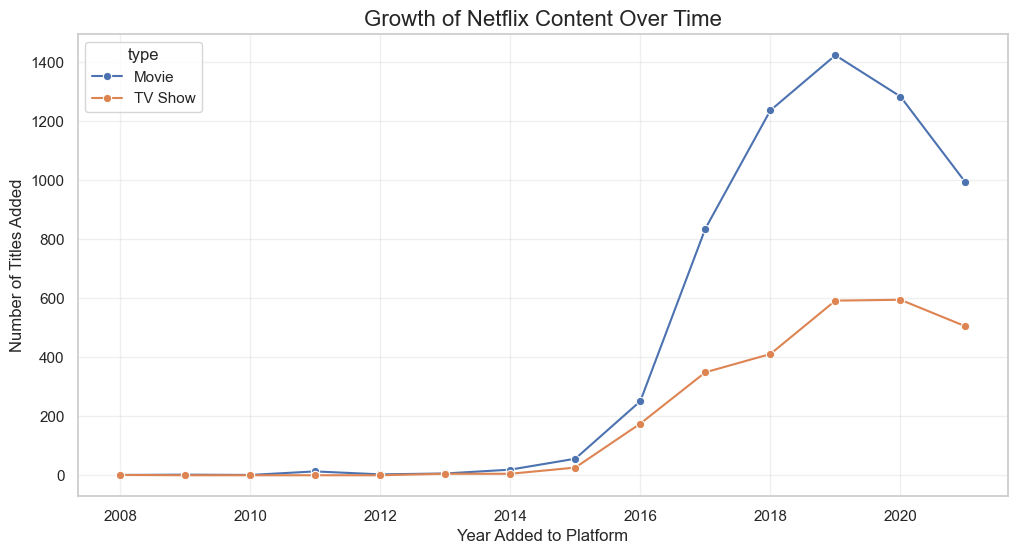

In [10]:
# 1. PRE-AGGREGATE: Create a summary of counts per year/type
# size() counts the rows, reset_index() turns it back into a clean DataFrame
summary_df = df.groupby(['year_added', 'type']).size().reset_index(name='count')

# 2. PLOT: Now Seaborn just has to draw the lines
plt.figure(figsize=(12, 6))

sns.lineplot(
    data=summary_df, 
    x='year_added', 
    y='count',       # Now 'y' is a real column we created above
    hue='type', 
    marker='o'
)

plt.title('Growth of Netflix Content Over Time', fontsize=16)
plt.xlabel('Year Added to Platform')
plt.ylabel('Number of Titles Added')
plt.grid(True, alpha=0.3) # Makes it easier to track values
plt.show()

/tmp/ipykernel_199021/4017475480.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rating_counts, x='rating', y='percentage', palette='viridis')


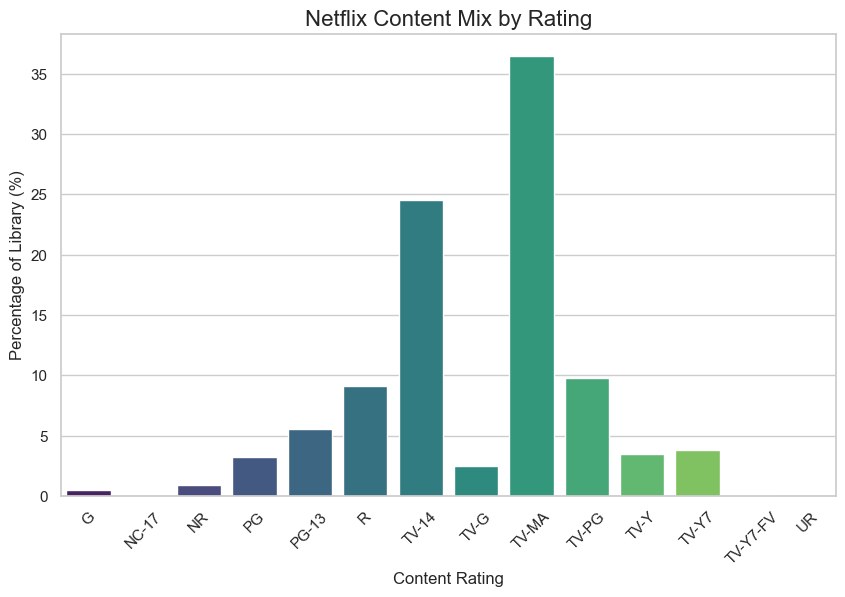

In [11]:
# 1. PRE-AGGREGATE: Calculate the percentage of each rating
rating_counts = df['rating'].value_counts(normalize=True).reset_index()
rating_counts.columns = ['rating', 'percentage']
rating_counts['percentage'] = rating_counts['percentage'] * 100

# 2. PLOT
plt.figure(figsize=(10, 6))
sns.barplot(data=rating_counts, x='rating', y='percentage', palette='viridis')

plt.title('Netflix Content Mix by Rating', fontsize=16)
plt.ylabel('Percentage of Library (%)')
plt.xlabel('Content Rating')
plt.xticks(rotation=45) 
plt.show()

/tmp/ipykernel_199021/1889171170.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gap_summary = df.groupby('type')['gap_years'].mean().reset_index()
/tmp/ipykernel_199021/1889171170.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gap_summary, x='type', y='gap_years', palette='coolwarm')


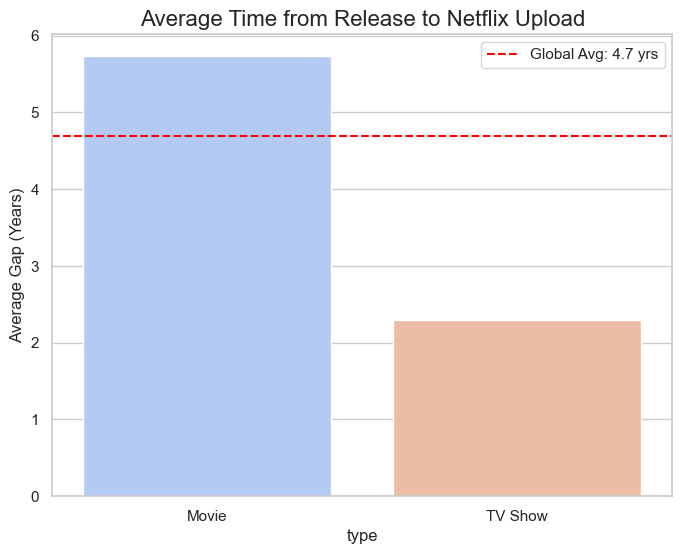

In [12]:
# 1. PRE-AGGREGATE: Calculate the average gap for Movies vs TV Shows
gap_summary = df.groupby('type')['gap_years'].mean().reset_index()

# 2. PLOT
plt.figure(figsize=(8, 6))
sns.barplot(data=gap_summary, x='type', y='gap_years', palette='coolwarm')

# 3. Add a "Mean Line" for context
overall_avg = df['gap_years'].mean()
plt.axhline(overall_avg, color='red', linestyle='--', label=f'Global Avg: {overall_avg:.1f} yrs')

plt.title('Average Time from Release to Netflix Upload', fontsize=16)
plt.ylabel('Average Gap (Years)')
plt.legend()
plt.show()

### Final Wrap-up of the Learning Project

We have covered the entire **Data Science Lifecycle**:

1. **Loading:** `pd.read_csv`
    
2. **Inspection:** `.info()` & `.isnull()`
    
3. **Cleaning:** `.fillna()` & `pd.to_datetime()`
    
4. **Engineering:** Creating `gap_years`
    
5. **Grouping:** `.groupby().agg()`
    
6. **Visualization:** Matplotlib & Seaborn